In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Load frequently used methods
with open("notebooks/methods.py", "r") as file:
    exec(file.read())

with open("python/detect_movement_episodes.py", "r") as file:
    exec(file.read())

with open("python/plot_all_events.py", "r") as file:
    exec(file.read())

# Movement detection using upper 10th percentile cutoff

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples.iloc[1]
sample

SID              W1_C2
AnimalID            W1
CellName            C2
Region          S1_L23
Date        2019 12 09
Depth       265.898093
Count              270
Location         W1/C2
Cortex              S1
Layer              L23
Name: 1, dtype: object

In [3]:
data = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/emg/filter.pkl")
channels = data.ch_names

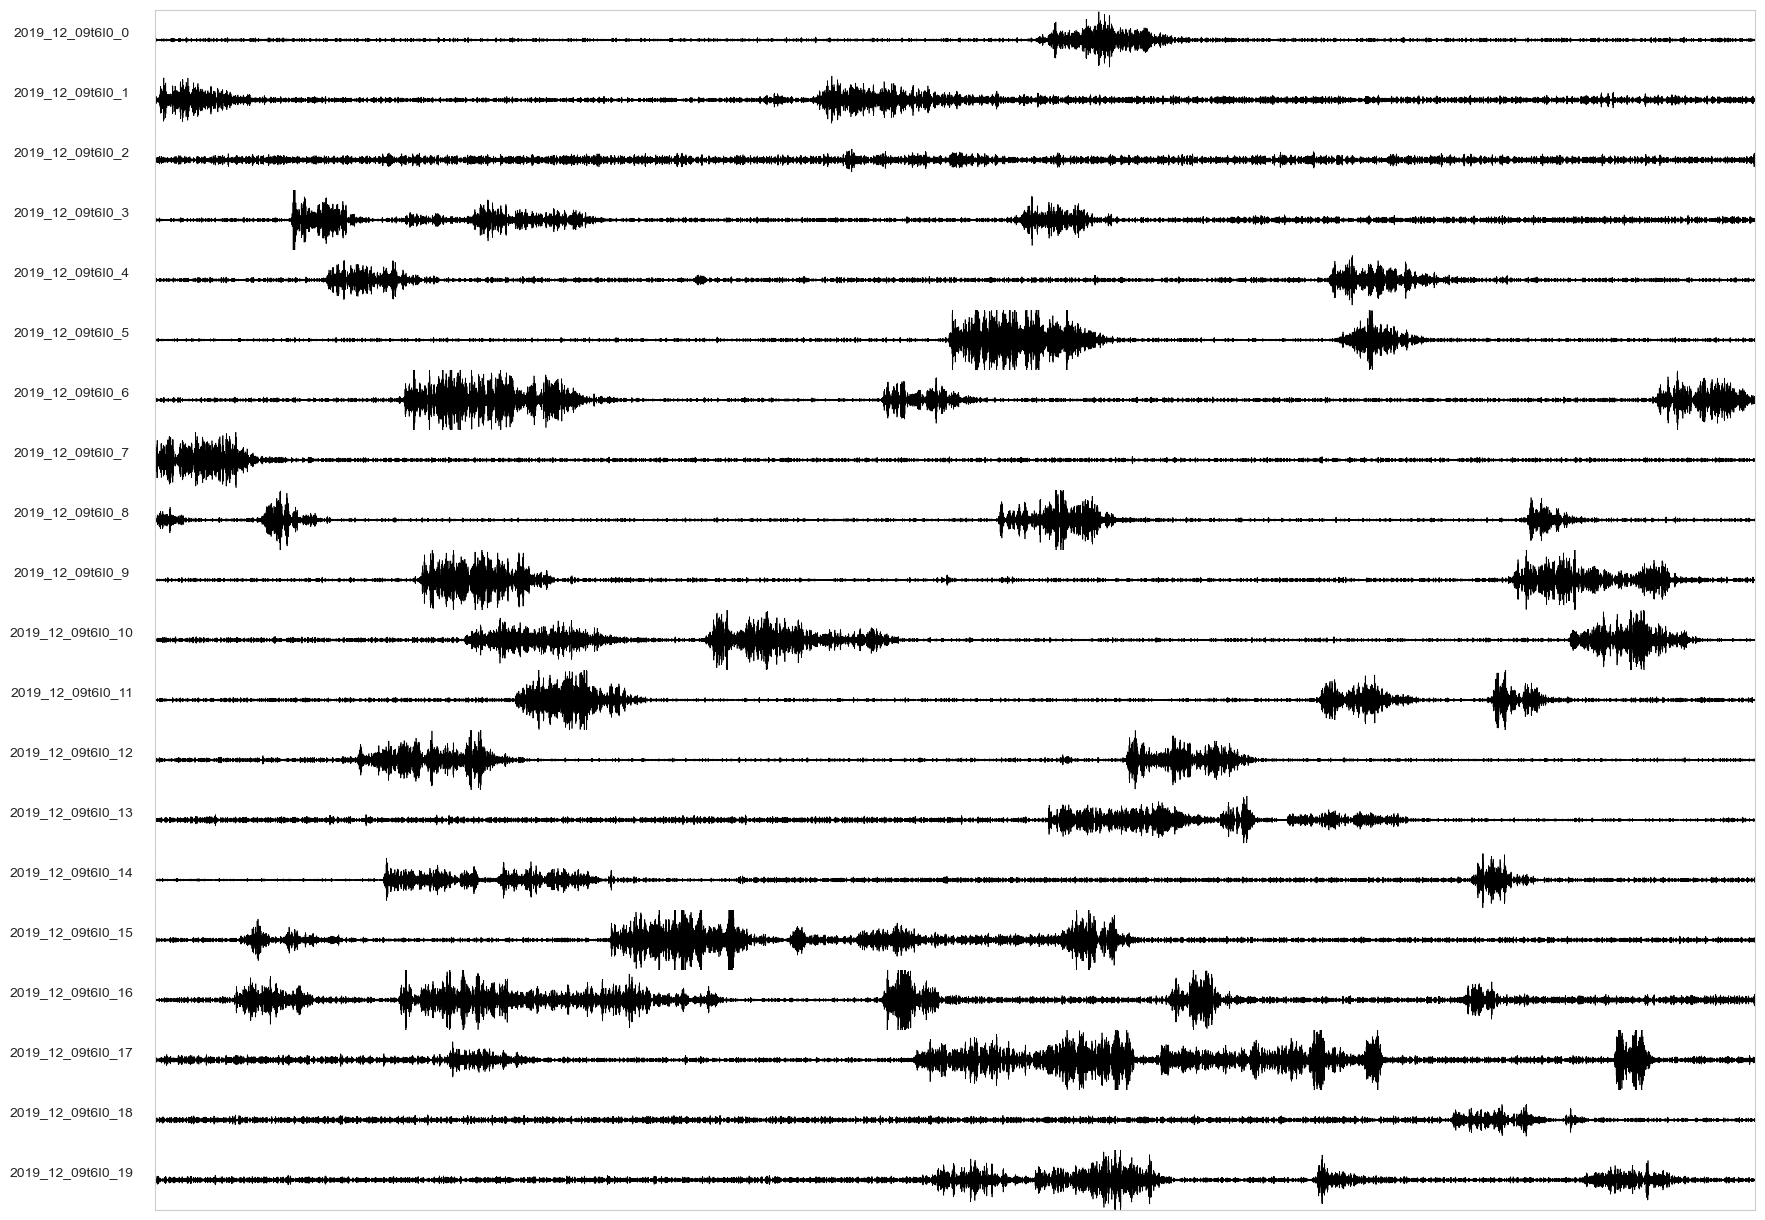

In [4]:
plot_channels(data = data.get_data().T, time = data.times, channels = channels, limit = 10)

## Movement episodes in a single channel

In [5]:
sample_data = data.get_data()
threshold = np.percentile(np.abs(sample_data), 90)
channel_data = sample_data[1]

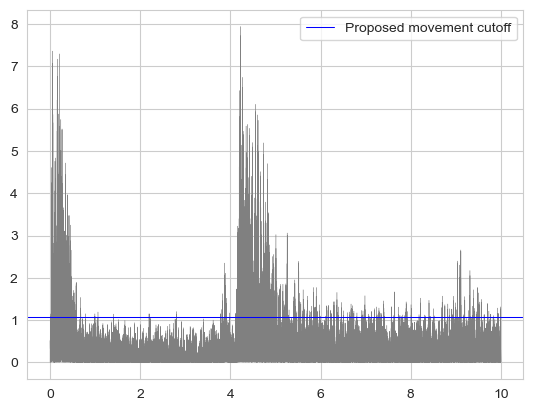

In [6]:
plt.plot(data.times, np.abs(channel_data), c = "gray", linewidth = 0.25)
plt.axhline(y = threshold, color = "blue", linestyle = "-", linewidth = 0.75, label = "Proposed movement cutoff")
plt.legend()
plt.show()

In [7]:
signal_over_threshold = np.abs(channel_data) > threshold
change_indices = np.where(np.diff(signal_over_threshold))[0]

movement_data = pd.DataFrame({
    "EventStart": np.insert(change_indices + 1, 0, 0),
    "EventEnd": np.append(change_indices + 1, len(signal_over_threshold))
})

movement_data["Movement"] = signal_over_threshold[movement_data["EventStart"]]
movement_data = movement_data[movement_data["Movement"]]
movement_data["EventLength"] = list(movement_data["EventEnd"] - movement_data["EventStart"])

movement_data = merge_close_events(movement_data, min_break = 500)

movement_data["Start"] = movement_data["EventStart"] / data.info["sfreq"]
movement_data["End"] = movement_data["EventEnd"] / data.info["sfreq"]
movement_data["Length"] = movement_data["EventLength"] / data.info["sfreq"]

movement_data = movement_data[movement_data["EventLength"] >= 5000]

In [8]:
movement_data

,EventStart,EventEnd,Movement,EventLength,Start,End,Length
0,95,11866,True,11771,0.00475,0.5933,0.58855
12,82253,102236,True,19983,4.11265,5.1118,0.99915


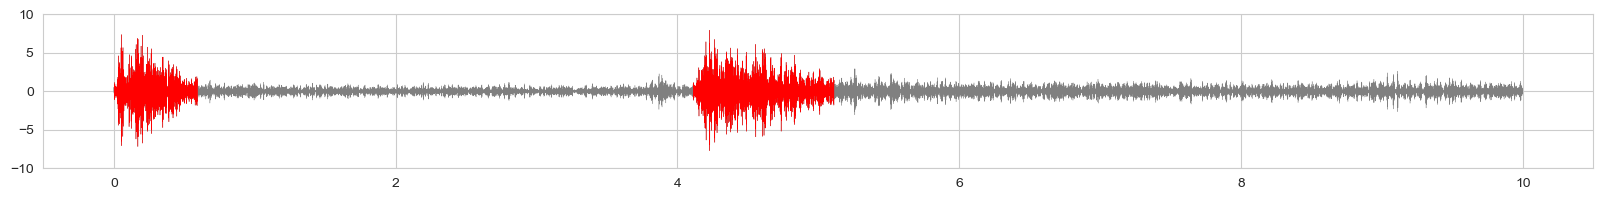

In [9]:
plt.figure(figsize = (20, 2))

x = data.times
y = channel_data

plt.plot(x, y, c = "gray", linewidth = 0.25)

for i, episode in movement_data.iterrows():
    x = data.times[episode["EventStart"]:episode["EventEnd"]]
    y = channel_data[episode["EventStart"]:episode["EventEnd"]]

    plt.plot(x, y, c = "red", linewidth = 0.25)

plt.ylim(-10, 10)
plt.show()

### Movement in all channels

In [10]:
sample_data = data.get_data()
threshold = np.percentile(np.abs(sample_data), 90)

episodes = []

for i, _ in enumerate(data.ch_names):
    signal = sample_data[i]
    
    ch_episodes = detect_movement_episodes(signal = signal, threshold = threshold, sfreq = data.info["sfreq"])
    ch_episodes["Channel"] = i
    episodes.append(ch_episodes)

episodes = pd.concat(episodes)
episodes = episodes.reset_index(drop = True)

episodes = episodes[ episodes["EventLength"] > 2500 ]

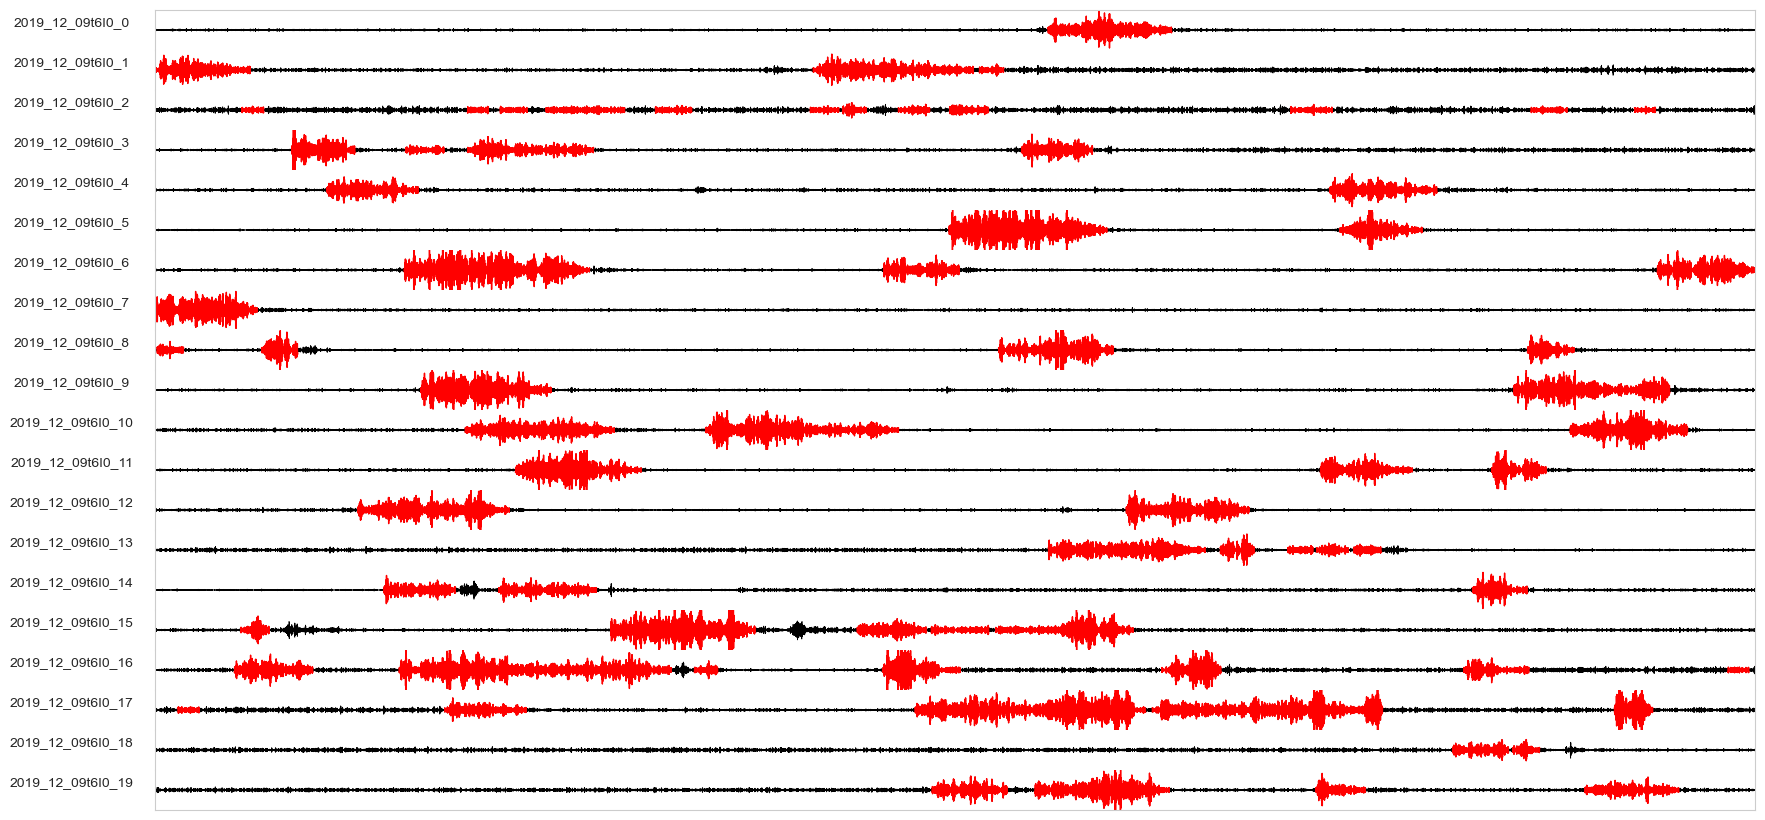

In [11]:
plot_all_events(data, channels = data.ch_names, movement = episodes, limit = 10)

### Average EMG during the onset of detected movement episode

In [12]:
raw = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/emg/raw.pkl")
raw.filter(l_freq = 2, h_freq = None, fir_design = "firwin", picks = "emg")

sample_data = raw.get_data()

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 33001 samples (1.650 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [13]:
episode_data = []

for i, episode in episodes.iterrows():
    if episode["EventStart"] < 500:
        continue
    
    start = episode["EventStart"] - 500
    end = episode["EventStart"] + 1000
    channel = episode["Channel"]

    episode_data.append(sample_data[channel][start:end])

episode_data = np.array(episode_data)

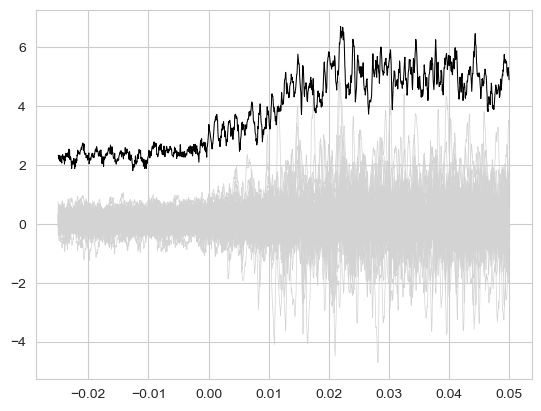

In [14]:
x = np.arange(-500, 1000, 1) / data.info["sfreq"]

for episode in episode_data:
    plt.plot(x, episode, c = "lightgray", linewidth = 0.5)

episode_data_mean = np.mean(np.abs(episode_data), axis = 0)

plt.plot(x, episode_data_mean * 10, c = "black", linewidth = 0.75)
plt.show()

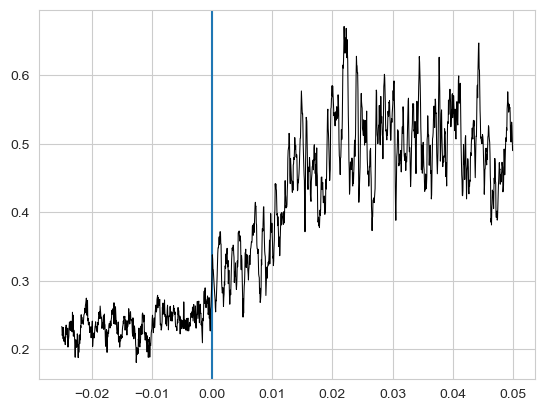

In [15]:
plt.axvline(x = 0, linestyle = "-")
plt.plot(x, episode_data_mean, c = "black", linewidth = 0.75)
plt.show()